# Simulate intrinsic noise of networks (Fig. S6)

Author: Jacob Parres-Gold (jacobparresgold@gmail.com)

Last Revised: 20231019

This notebook will use stochastic stimulations, via Gillespie simulation, of networks at steady state to estimate stochastic fluctuations in dimer concentrations at equilibrium.

Here, I am going to assume that all coiled-coils have about the same $k_{on}$ rate of $5 \times 10^{5} M^{-1}s^{-1}$ as per [this reference](https://doi.org/10.1021/bi9530604), and that differences in affinity are thus due to differences in $k_{off}$. 

To convert from arbitrary K units to real molecule counts, I will consider 0.001 (unitless), which was our lower concentration limit in the large parameter screen, as 1 molecule. I will consider the volume of a mammalian cell as approximately 3 pL ($10^{-12} L$). 

In [1]:
import os
import sys
import pathlib

import itertools
import numpy as np
import progressbar
import time
import datetime

# Plotting
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as mticker
from matplotlib import rcParams

# EQTK to calculate equilibrium concentrations - install instructions here https://eqtk.github.io/getting_started/eqtk_installation.html
import eqtk

# Ray for parallelization - install instructions here https://docs.ray.io/en/latest/ray-overview/installation.html
import ray

# Numba for speed increase in Gillespie simulations - install instructions here https://numba.readthedocs.io/en/stable/user/installing.html
import numba

# Networkx for graphs - install instructions here https://networkx.org/documentation/stable/install.html
import networkx as nx

In [2]:
# Load utility functions from dimer_network_utilities.py
utilities_path = str(pathlib.Path('C:\\Users','jacob','Local_Coding',\
                                  'ElowitzLab','Promiscuous_Networks','Notebooks','Paper_Notebooks')) # Directory of your utilities.py file
sys.path.append(utilities_path)
from dimer_network_utilities import *

In [3]:
# Initialize ray
_ = ray.init(ignore_reinit_error=True)

In [ ]:
# To shut down ray:
# ray.shutdown()

In [3]:
# Define directory to save to
out_dir = str(pathlib.Path('C:\\Users','jacob','Downloads'))

if not os.path.isdir(out_dir):
    os.mkdir(out_dir)

In [4]:
# Plotting settings
rcParams.update({
    "text.usetex": False,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"],	
    "font.size":9,
    "axes.titlesize":9,
    "axes.labelsize":9,
    "xtick.labelsize":9,
    "ytick.labelsize":9,
    "savefig.dpi": 900, 
    'figure.figsize': [6.0, 4.0],
    'figure.dpi': 150,
    'pdf.fonttype':42,
    'ps.fonttype':42,
})

In [5]:
# Print package versions
import pkg_resources
imports = list(set(get_imports()))
requirements = []
for m in pkg_resources.working_set:
    if m.project_name in imports and m.project_name!="pip":
        requirements.append((m.project_name, m.version))

print("Package versions:")
print("python={}".format(sys.version.split('|')[0].replace(' ','')))
for r in requirements:
    print("{}={}".format(*r))

Package versions:
python=3.8.13
eqtk=0.1.3
matplotlib=3.7.1
networkx=2.7.1
numpy=1.21.5
pandas=1.4.1
scipy=1.10.1


## Define simulation function

In [6]:
def run_eqtk(N, C0, params, num_inputs,num_rxns, acc_monomer_ind):
    """
    Run eqtk.solve given the input stoichiometry matrix (N), initial concentrations (C0), and parameters (params)
    Parameters includes includes Kij values and accessory monomer levels. 
    """
    K = params[:num_rxns]
    C0[:,acc_monomer_ind] = params[num_rxns:]

    return eqtk.solve(c0=C0, N=N, K=K)

In [7]:
def simulate_networks_manual(m, num_inputs, param_sets, t = 12, input_lb = -3, input_ub = 3):
    """
    Run simulations for dimer networks, over a matrix of concentrations for multiple monomers. 
    When >1 monomers are varied (e.g., a 2D matrix), the first monomer is sampled outermost, while the second
    is sampled inner to that.
    
    Parameters
    ----------
    m : int. 
        Number of monomer species. 
    num_inputs: int
        Number of monomers to count as inputs (those titrated). 
        E.g., if num_inputs=2, the first two monomers will be treated as inputs.
    t : int. Default 12. 
        Number of values to titrate each input monomer species. 
        Values spaced evenly on a log10 scale
    input_lb : int. Default -3
        lower bound for titrating the input monomer species. log10 scale
    input_ub : int. Default 3
        upper bound for titrating the input monomer species. log10 scale
    param_sets : array_like shape (num_sets, num_parameters)
        Parameters sets for simulating dimerization networks.  
    Returns
    -------
    C0 : array_like shape (t, number of species)
        Initial concentration array used for eqtk.solve
    S_all : array_like 
        Equlibrium concentration of all species (monomers & dimers)
        for all parameter sets. 
        
    """
    #Create stoichiometry matrix and initial concnetration matrix 
    num_sets = param_sets.shape[0]
    N = make_nXn_stoich_matrix(m)
    num_rxns = N.shape[0]
    M0_min = [input_lb]*num_inputs + [0] * (m-num_inputs)
    M0_max = [input_ub]*num_inputs + [0] * (m-num_inputs)
    num_conc = [t]*num_inputs + [1] * (m-num_inputs)

    C0 = make_C0_grid(m, M0_min=M0_min, M0_max=M0_max, num_conc=num_conc)
        
    acc_monomer_ind = np.arange(num_inputs,m)
    S_all = np.zeros((C0.shape[0], C0.shape[1], num_sets))
    for pset_index, pset in enumerate(param_sets):
        S_all[:,:,pset_index] = run_eqtk(N, C0.copy(), pset, num_inputs, num_rxns,acc_monomer_ind)
    return C0,S_all  

## Define General Constants

In [8]:
# Physical constants
vol_per_cell = 1e-12 # L - estimated for mammalian cell
unitless_conc_per_molecule = 0.001 # Our screen uses concentrations from 0.001 - 1000. We will use a similar range, but consider 0.001 as one molecule per cell.
k_on = 5e5 # M-1 s-1, on rate for binding. This will be the same for every dimerization reaction.
k_on_unitless = k_on/6.0221e23/vol_per_cell # (molecule/cell)-1 s-1, off rate for binding

In [9]:
t = 30 # Number of input points simulated
input_lb = -3 # Lower bound of input concentrations, in log space
input_ub = 3 # Upper bound of input concentrations, in log space
x_points = np.logspace(input_lb,input_ub,t,endpoint=True)

In [10]:
null_K = 1e-10 # Affinity value to use for no binding
K_log_range = [-3,1] # Range of unitless affinity values to test, in log space.
                        # Corresponds to "affinities" of ~100 pM to ~1 μM
A_log_range = [input_lb,input_ub]# Range of accessory  values to test
null_K_homo_fraction=0.25 # Approximate fraction of homodimerization reactions that will not be made possible

## Simulate single case: Generate Parameter Set

In [11]:
m = 8 # Network size

species = make_nXn_species_names(m) # All species in system

dimers = np.array(list(itertools.combinations_with_replacement(range(m),2))) # All dimer combinations

In [12]:
edge_key = {}
homo_edges = []
hetero_edges = []

# Categorize edge types
for i,combo in enumerate(itertools.combinations_with_replacement(range(m),r=2)):
    edge_key[(combo[0],combo[1])] = i
    if combo[0]==combo[1]:
        homo_edges.append(i)
    else:
        hetero_edges.append(i)

Now generate a parameter set:

In [13]:
min_edges = m - 1
max_edges = num_combos(m,2)
num_edges = 7 # Decide on number of edges to use - minimum m - 1, maximum num_combos(m,2)

param_set = np.concatenate((np.full((num_combos_with_replacement(m,r=2),),null_K),np.ones((m-1,))))
graph = nx.gnm_random_graph(n=m,m=num_edges)
if num_edges<=math.comb(m-1,2):
    # If false, graph is always connected
    while not nx.is_connected(graph):
        graph = nx.gnm_random_graph(n=m,m=num_edges)
edge_indices = [edge_key[x] for x in graph.edges]
# Fill heterodimer K's
rng = np.random.default_rng()
param_set[edge_indices] = 10**rng.uniform(K_log_range[0],K_log_range[1],size=(num_edges,))
# Fill homodimer K's
homo_edges_tofill = rng.choice(homo_edges,size=(round((1-null_K_homo_fraction)*m),),replace=False)
param_set[homo_edges_tofill] = 10**rng.uniform(K_log_range[0],K_log_range[1],size=homo_edges_tofill.shape)
# Fill A's
param_set[-(m-1):] = 10**rng.uniform(A_log_range[0],A_log_range[1],size=(m-1,))

param_sets = np.expand_dims(param_set,axis=0)

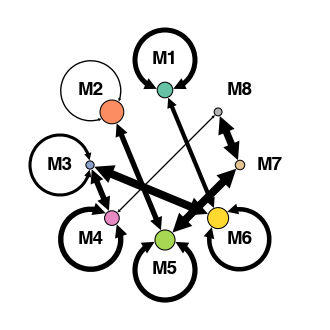

In [18]:
fig, axs = make_network_plots_polygon(m=m, n_input=1,param_sets=np.expand_dims(param_sets[0],axis=0), \
                                        univs_to_plot=np.array([0]),\
                                        ncols = 1,r_node = 0.5, r_loop = 0.2,\
                                        node_scales = [-3,3,4,12], input_node_values=np.array([0 for x in range(1)]),\
                                        K_edge_scales = [-3,1,0.5,4],input_cmap='Set2',\
                                        fontname = 'Helvetica',fontsize=9,non_output_dimer_color='k')

fig.set_dpi(150)

In [19]:
# Convert to more relevant units
K = param_set[:num_combos_with_replacement(m,2)] # Affinities
K_molec = K*unitless_conc_per_molecule # (molecule/cell)-1, affinities in molecule units
k_offs = k_on_unitless/K_molec # s-1, binding off rates, for each dimer

Solve the equilibrium concentrations across an input titration

In [20]:
C0, S_all = simulate_networks_manual(m, num_inputs=1, param_sets=param_sets, t = t, input_lb = -3, input_ub = 3)

Rather than make the initial species amounts all monomers, we're going to use the concentrations at equilibrium for the lowest input value. We're then going to increase the input to the highest value (or vice versa) and see how long it takes to re-equilibrate.

In [22]:
initial_equilibrium_species_concs = S_all[0,:,0] # Dimensionless
initial_equilibrium_species_concs_molec = initial_equilibrium_species_concs/unitless_conc_per_molecule # molecule/cell

# Then re-adjust input concentration
initial_equilibrium_species_concs_molec[0] = x_points[-1]/unitless_conc_per_molecule

dimers = np.array(list(itertools.combinations_with_replacement(range(m),2)))

For information, please refer to [this page](https://biocircuits.github.io/chapters/16_bursty.html?highlight=gillespie#Sampling-out-of-master-equations) and [this appendix for speeding it up with Numba](https://biocircuits.github.io/chapters/appB_gillespie.html?highlight=gillespie).

## Stochastic Simulations (Gillespie)

We must make an array of update rules, describing how all species counts change upon each reaction

In [ ]:
update_rules = np.vstack((make_nXn_stoich_matrix(m = m),-make_nXn_stoich_matrix(m = m)))

### General Functions for Gillespie Simulation

Create functions to:
* Update the reaction probabilities for the current number of each species, each iteration
* Choose which reaction occurs based on reaction probabilities
* Draws a reaction and the time it took to do that reaction
* Perform the overall Gillespie simulation

Numba was used to significantly speed of these calculations (nearly 100 fold), referring to [this link](https://biocircuits.github.io/chapters/appB_gillespie.html?highlight=gillespie) by Justin Bois for reference.

In [ ]:
@numba.njit
def update_propensities(propensities, population, t, k_on_unitless, k_offs,dimers):
    # dimers = list(itertools.combinations_with_replacement(range(m),2))
    num_dimers = len(dimers)
    for dimer,monomers in enumerate(dimers):
        # On reaction
        propensities[dimer] = k_on_unitless*population[monomers[0]]*population[monomers[1]]
        # Off reaction
        propensities[num_dimers+dimer] = k_offs[dimer]*population[m+dimer]

In [ ]:
@numba.njit
def sample_discrete_numba(probs, probs_sum):
    q = np.random.rand() * probs_sum

    i = 0
    p_sum = 0.0
    while p_sum < q:
        p_sum += probs[i]
        i += 1
    return i - 1

In [ ]:
@numba.njit
def gillespie_draw_numba(propensities, population, t, args):
    """
    Draws a reaction and the time it took to do that reaction.

    Assumes that there is a globally scoped function
    `update_propensities` that is Numba'd with nopython=True.
    """
    # Compute propensities
    update_propensities(propensities, population, t, *args)

    # Sum of propensities
    props_sum = np.sum(propensities)

    # Compute time
    time = np.random.exponential(1 / props_sum)

    # Draw reaction given propensities
    rxn = sample_discrete_numba(propensities, props_sum)

    return rxn, time

In [ ]:
@numba.njit
def gillespie_ssa_numba(update, population_0, time_points, args):
    """
    Uses the Gillespie stochastic simulation algorithm to sample
    from proability distribution of particle counts over time.

    Parameters
    ----------
    update : ndarray, shape (num_reactions, num_chemical_species)
        Entry i, j gives the change in particle counts of species j
        for chemical reaction i.
    population_0 : array_like, shape (num_chemical_species)
        Array of initial populations of all chemical species.
    time_points : array_like, shape (num_time_points,)
        Array of points in time for which to sample the probability
        distribution.
    args : tuple, default ()
        The set of parameters to be passed to propensity_func.

    Returns
    -------
    sample : ndarray, shape (num_time_points, num_chemical_species)
        Entry i, j is the count of chemical species j at time
        time_points[i].

    Notes
    -----
    .. Assumes that there is a globally scoped function
       `propensity_func` that is Numba'd with nopython=True.
    """
    # Initialize output
    pop_out = np.empty((len(time_points), update.shape[1]), dtype=np.int64)

    # Initialize and perform simulation
    i_time = 1
    i = 0
    t = time_points[0]
    population = population_0.copy()
    pop_out[0,:] = population
    propensities = np.zeros(update.shape[0])
    while i < len(time_points):
        while t < time_points[i_time]:
            # draw the event and time step
            event, dt = gillespie_draw_numba(propensities, population, t, args)

            # Update the population
            population_previous = population.copy()
            population += update[event,:]

            # Increment time
            t += dt

        # Update the index (Have to be careful about types for Numba)
        i = np.searchsorted((time_points > t).astype(np.int64), 1)

        # Update the population
        for j in np.arange(i_time, min(i, len(time_points))):
            pop_out[j,:] = population_previous

        # Increment index
        i_time = i

    return pop_out

### Run simulations at equilibrium:

In [ ]:
eq_species_amounts = np.around(S_all[input_i,:,param_set_i]/unitless_conc_per_molecule) # molecule/cell units

In [ ]:
time_len_eq = 1000 # s, time to run Gillespie simulation (time steps every 10 s)
timepoints_eq = np.linspace(0, time_len_eq, time_len_eq//10, endpoint=True)

In [ ]:
# Initialize output array
gillespie_simulations = np.empty((len(timepoints_eq), len(make_nXn_species_names(m))), dtype=np.int64)
gillespie_simulations = gillespie_ssa_numba(
    update=update_rules,
    population_0=eq_species_amounts,
    time_points=timepoints_eq,
    args=(k_on_unitless, k_offs,dimers),
)

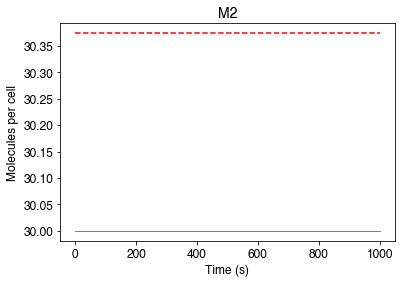

In [ ]:
species_to_plot = make_nXn_species_names(m).index('M2')

fig, ax = plt.subplots()

_ = ax.plot(timepoints_eq,gillespie_simulations[:,species_to_plot].T,marker='',linestyle='-',\
            lw=1,alpha=0.5,color='k')

_ = ax.hlines(xmin=timepoints_eq[0],xmax=timepoints_eq[-1],y=S_all[input_i,species_to_plot,param_set_i]/unitless_conc_per_molecule,linestyle='--',color='r')

_ = ax.set_xlabel('Time (s)')
_ = ax.set_ylabel(f'Molecules per cell')
_ = ax.set_title(f'{make_nXn_species_names(m)[species_to_plot]}')

ax.get_yaxis().get_major_formatter().set_useOffset(False)

# Create Legend
patches = {}
patches['simulation'] = mlines.Line2D([],[],linestyle='-',linewidth=2,color='k', label='Deterministic Simulation')
patches['equilibrium'] = mlines.Line2D([],[],linestyle='--',linewidth=2,color='r', label='Known Equilibrium')

leg = fig.legend(bbox_to_anchor=(1, 0.5), loc='center left',facecolor='none',\
    handles=list(patches.values()),\
    edgecolor='none')

### Analyze Noise at Equilibrium

Noise will be defined either as the coefficient of variation $\eta$, a relative measure:

$$\eta = \frac{\langle x^{2} \rangle - \langle x \rangle ^{2}}{\langle x \rangle ^{2}}$$

Or as simply the standard deviation of molecule counts over all timepoints, a more absolute measure:

$$\sigma = \sqrt{\frac{\sum_{n=1}^{\infty} x_{i} - \langle x \rangle }{N}}$$

where $N$ is the total number of timepoints.

See [this page](https://biocircuits.github.io/chapters/15_noise.html#Types-of-noise) for more information.

In [ ]:
coeff_noise = []
stdev_noise = []
for species in range(m+num_combos_with_replacement(m,2)):
    # compute relative noise as coeff of variation
    coeff_noise.append(scipy.stats.variation(\
                    gillespie_simulations[:,species]))
    # compute absolute noise as just stdev
    stdev_noise.append(np.std(\
                    gillespie_simulations[:,species]))

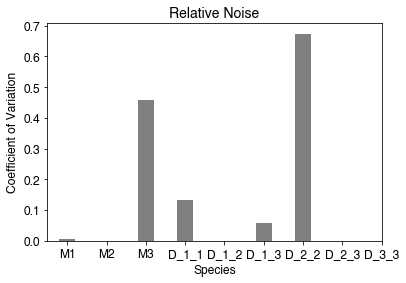

In [ ]:
fig, ax = plt.subplots()

ax.bar(list(range(m+num_combos_with_replacement(m,2))),coeff_noise,width=0.4,color='gray')

_ = ax.set_xticks(list(range(m+num_combos_with_replacement(m,2))),labels=make_nXn_species_names(m))

_ = ax.set_ylabel('Coefficient of Variation')
_ = ax.set_xlabel('Species')
_ = ax.set_title('Relative Noise')

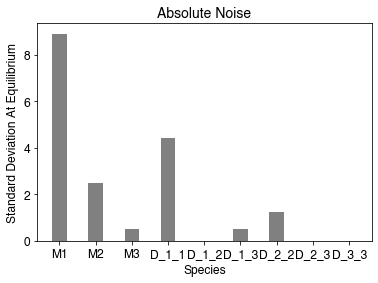

In [ ]:
fig, ax = plt.subplots()

ax.bar(list(range(m+num_combos_with_replacement(m,2))),stdev_noise,width=0.4,color='gray')

_ = ax.set_xticks(list(range(m+num_combos_with_replacement(m,2))),labels=make_nXn_species_names(m))

_ = ax.set_ylabel('Standard Deviation At Equilibrium')
_ = ax.set_xlabel('Species')
_ = ax.set_title('Absolute Noise')

## Screen Several Parameter Sets: Intrinsic Noise

In [ ]:
out_dir = str(pathlib.Path('/','home','ubuntu','Data','20230310_intrinsic_noise'))

if not os.path.isdir(out_dir):
    os.mkdir(out_dir)

In [ ]:
param_sets_per_m = 20 # Number of parameter sets to simulate per network size

In [ ]:
vol_per_cell = 1e-12 # L, estimated for mammalian cell
unitless_conc_per_molecule = 0.001 

k_on = 5e5 # M-1 s-1
k_on_unitless = k_on/6.0221e23/vol_per_cell # molecule-1 s-1

In [ ]:
t = 30 # Number of input points simulated
input_lb = -3 # Lower bound of input concentrations, in log space
input_ub = 3 # Upper bound of input concentrations, in log space
x_points = np.logspace(input_lb,input_ub,t,endpoint=True) # Input concentrations

In [ ]:
rng = np.random.default_rng()

In [ ]:
# This seems needed for numba/ray compatibility
# https://discuss.ray.io/t/ray-is-not-compatible-with-numba-cuda-when-import/1274/2
import sys
module_name = globals()['__name__']
current_module = sys.modules[module_name]

In [ ]:
@ray.remote
def ray_analyze_intrinsic_noise(m,m_i):
    sys.modules[module_name] = current_module
    time1 = time.time()
    
    # Define JIT'd function for Gillespies
    ###
    @numba.njit
    def update_propensities(propensities, population, t, k_on_unitless, k_offs,dimers):
        # dimers = list(itertools.combinations_with_replacement(range(m),2))
        num_dimers = len(dimers)
        for dimer,monomers in enumerate(dimers):
            # On reaction
            propensities[dimer] = k_on_unitless*population[monomers[0]]*population[monomers[1]]
            # Off reaction
            propensities[num_dimers+dimer] = k_offs[dimer]*population[m+dimer]
    
    @numba.njit
    def sample_discrete_numba(probs, probs_sum):
        q = np.random.rand() * probs_sum

        i = 0
        p_sum = 0.0
        while p_sum < q:
            p_sum += probs[i]
            i += 1
        return i - 1
    
    @numba.njit
    def gillespie_draw_numba(propensities, population, t, args):
        """
        Draws a reaction and the time it took to do that reaction.

        Assumes that there is a globally scoped function
        `update_propensities` that is Numba'd with nopython=True.
        """
        # Compute propensities
        update_propensities(propensities, population, t, *args)

        # Sum of propensities
        props_sum = np.sum(propensities)

        # Compute time
        time = np.random.exponential(1 / props_sum)

        # Draw reaction given propensities
        rxn = sample_discrete_numba(propensities, props_sum)

        return rxn, time
    
    @numba.njit
    def gillespie_ssa_numba(update, population_0, time_points, args):
        # Initialize output
        pop_out = np.empty((len(time_points), update.shape[1]), dtype=np.int64)

        # Initialize and perform simulation
        i_time = 1
        i = 0
        t = time_points[0]
        population = population_0.copy()
        pop_out[0,:] = population
        propensities = np.zeros(update.shape[0])
        while i < len(time_points):
            while t < time_points[i_time]:
                # draw the event and time step
                event, dt = gillespie_draw_numba(propensities, population, t, args)

                # Update the population
                population_previous = population.copy()
                population += update[event,:]

                # Increment time
                t += dt

            # Update the index (Have to be careful about types for Numba)
            i = np.searchsorted((time_points > t).astype(np.int64), 1)

            # Update the population
            for j in np.arange(i_time, min(i, len(time_points))):
                pop_out[j,:] = population_previous

            # Increment index
            i_time = i

        return pop_out
    ###
    input_i_by_pset = []
    k_offs_by_pset_by_species = []
    coeff_noise_by_pset_by_species = []
    stdev_noise_by_pset_by_species = []
    reports = []
    
    edge_key = {}
    homo_edges = []
    hetero_edges = []

    for i,combo in enumerate(itertools.combinations_with_replacement(range(m),r=2)):
        edge_key[(combo[0],combo[1])] = i
        if combo[0]==combo[1]:
            homo_edges.append(i)
        else:
            hetero_edges.append(i)
    
    min_edges = m - 1
    max_edges = num_combos(m,2)
    num_possible_num_edges = max_edges - min_edges + 1
    possible_num_edges = list(range(min_edges,max_edges+1))
    num_edges_to_test = np.array(possible_num_edges)[np.array([round(x) for x in np.linspace(0,num_possible_num_edges-1,param_sets_per_m)])]
    
    null_K = 1e-10
    K_log_range = [-3,1]
    A_log_range = [-3,3]
    null_K=1e-10
    null_K_homo_fraction=0.25
    
    param_sets = np.concatenate((np.full((param_sets_per_m,num_combos_with_replacement(m,r=2)),null_K),np.ones((param_sets_per_m,m-1))),axis=1)
    
    t = 30
    input_lb = -3
    input_ub = 3
    S_all = np.zeros((t,num_combos_with_replacement(m,2)+m,param_sets_per_m))
    
    for param_set_i, num_edges in enumerate(num_edges_to_test):
        report = f"\tParameter set {param_set_i}\n"
        report+= f"\t\tTime since start: {str(datetime.timedelta(seconds=round(time.time()-t1,0)))}\n"
        
        param_set = param_sets[param_set_i]
        graph = nx.gnm_random_graph(n=m,m=num_edges)
        if num_edges<=math.comb(m-1,2):
            # If false, graph is always connected
            while not nx.is_connected(graph):
                graph = nx.gnm_random_graph(n=m,m=num_edges)
        edge_indices = [edge_key[x] for x in graph.edges]
        # Fill heterodimer K's
        param_set[edge_indices] = 10**rng.uniform(K_log_range[0],K_log_range[1],size=(num_edges,))
        # Fill homodimer K's
        homo_edges_tofill = rng.choice(homo_edges,size=(round((1-null_K_homo_fraction)*m),),replace=False)
        param_set[homo_edges_tofill] = 10**rng.uniform(K_log_range[0],K_log_range[1],size=homo_edges_tofill.shape)
        # Fill A's
        param_set[-(m-1):] = 10**rng.uniform(A_log_range[0],A_log_range[1],size=(m-1,))
        
        param_sets[param_set_i] = param_set
        
        C0, S_all_temp = simulate_networks_manual(m, num_inputs=1, param_sets=np.expand_dims(param_set,axis=0), t = t, input_lb = -3, input_ub = 3)
        S_all[:,:,param_set_i] = S_all_temp[:,:,0]

        K = param_sets[param_set_i,:num_combos_with_replacement(m,2)]
        K_molec = K*unitless_conc_per_molecule # molecule-1
        k_offs = k_on_unitless/K_molec # s-1

        input_i = rng.integers(t)
        input_val = x_points[input_i]
        input_molec = input_val/unitless_conc_per_molecule # molecule

        dimers = np.array(list(itertools.combinations_with_replacement(range(m),2)))

        # Gillespie
        report+=f"\t\tSimulating Stochastic Noise\n"
        eq_species_amounts = np.around(S_all[input_i,:,param_set_i]/unitless_conc_per_molecule)
        time_len_eq = 1000 # s
        timepoints_eq = np.linspace(0, time_len_eq, time_len_eq//10, endpoint=True)

        update_rules = np.vstack((make_nXn_stoich_matrix(m = m),-make_nXn_stoich_matrix(m = m)))

        # Initialize output array
        gillespie_simulations = np.empty((len(timepoints_eq), len(make_nXn_species_names(m))), dtype=np.int64)
        gillespie_simulations = gillespie_ssa_numba(
            update=update_rules,
            population_0=eq_species_amounts,
            time_points=timepoints_eq,
            args=(k_on_unitless, k_offs,dimers),
        )
        report+="\t\tProcessing Stochastic Data\n"
        coeff_noise = []
        stdev_noise = []
        for species in range(m+num_combos_with_replacement(m,2)):
            # compute relative noise as coeff of variation
            coeff_noise.append(scipy.stats.variation(\
                            gillespie_simulations[:,species]))
            # compute absolute noise as just stdev
            stdev_noise.append(np.std(\
                            gillespie_simulations[:,species]))

        del gillespie_simulations

        report+= f"\t\tTime since start: {str(datetime.timedelta(seconds=round(time.time()-t1,0)))}\n"

        k_offs_by_pset_by_species.append(k_offs)
        input_i_by_pset.append(input_i)
        coeff_noise_by_pset_by_species.append(coeff_noise)
        stdev_noise_by_pset_by_species.append(stdev_noise)
        reports.append(report)
    
    reports_sorted = list(sorted(reports,key=lambda x: int(''.join([c for c in x[:18] if c.isnumeric()]))))
    
    specific_out_dir = str(pathlib.Path(out_dir,f'{m}M'))
    if not os.path.isdir(specific_out_dir):
        os.mkdir(specific_out_dir)
    np.save(str(pathlib.Path(specific_out_dir,f'param_sets.npy')),param_sets)
    np.save(str(pathlib.Path(specific_out_dir,f'S_all.npy')),S_all)
    np.save(str(pathlib.Path(specific_out_dir,f'num_edges_to_test.npy')),num_edges_to_test)
    np.save(str(pathlib.Path(specific_out_dir,f'k_offs_by_pset_by_species.npy')),k_offs_by_pset_by_species)
    np.save(str(pathlib.Path(specific_out_dir,f'input_i_by_pset.npy')),input_i_by_pset)
    np.save(str(pathlib.Path(specific_out_dir,f'coeff_noise_by_pset_by_species.npy')),coeff_noise_by_pset_by_species)
    np.save(str(pathlib.Path(specific_out_dir,f'stdev_noise_by_pset_by_species.npy')),stdev_noise_by_pset_by_species)
    np.save(str(pathlib.Path(specific_out_dir,f'intrinsic_noise_reports.npy')),reports_sorted)
    
    print(f"Finished m={m}")
    
    return

In [ ]:
futures = []
t1 = time.time()
for m in m_list[:1]:
    m_i = m_list.index(m)
    futures.append(ray_analyze_intrinsic_noise.remote(m,m_i))

results = []
for future in futures:
    results.append(ray.get(future))

(ray_analyze_intrinsic_noise pid=34130) Finished m=2


## Plots

In [ ]:
m_list = list(range(2,13))

vol_per_cell = 1e-12 # L, estimated for mammalian cell
unitless_conc_per_molecule = 0.001

k_on = 5e5 # M-1 s-1
k_on_unitless = k_on/6.0221e23/vol_per_cell # molecule-1 s-1


In [ ]:
t = 30 # Number of input points simulated
input_lb = -3 # Lower bound of input concentrations, in log space
input_ub = 3 # Upper bound of input concentrations, in log space
x_points = np.logspace(input_lb,input_ub,t,endpoint=True) # Input concentrations

In [ ]:
param_sets_per_m = 20 # Number of parameter sets to simulate per network size

In [ ]:
rng = np.random.default_rng()

In [ ]:
def moving_average(x_vals, y_vals, window_size=None, num_windows=50):
    if window_size is None:
        x_range = np.max(x_vals) - np.min(x_vals)
        window_size = x_range/5
    x_window_centers = np.linspace(np.min(x_vals),np.max(x_vals),\
                                   num_windows,endpoint=True)
    x_window_means = [(x, np.mean(y_vals[np.where((x_vals>=x_window_centers[window]-(window_size/2))&\
                                                (x_vals<=x_window_centers[window]+(window_size/2)))[0]])) \
                        if len(y_vals[np.where((x_vals>=x_window_centers[window]-(window_size/2))&\
                                                (x_vals<=x_window_centers[window]+(window_size/2)))[0]])>0\
                        else (x, np.nan) \
                        for x, window in zip(x_window_centers,range(num_windows))]
    return np.array(x_window_means)

In [ ]:
out_dir = str(pathlib.Path('/','home','ubuntu','Data','20230310_intrinsic_noise'))

Load data:

In [ ]:
param_sets_by_m = []
S_all_by_m = []
num_edges_to_test_by_m = []
k_offs_by_m_by_pset_by_species = []
input_i_by_m_by_pset = []
coeff_noise_by_m_by_pset_by_species = []
stdev_noise_by_m_by_pset_by_species = []   

for m in m_list:
    m_i = m_list.index(m)
    specific_out_dir = str(pathlib.Path(out_dir,f'{m}M'))
    param_sets_by_m.append(np.load(str(pathlib.Path(specific_out_dir,f'param_sets.npy')),allow_pickle=True))
    S_all_by_m.append(np.load(str(pathlib.Path(specific_out_dir,f'S_all.npy')),allow_pickle=True))
    num_edges_to_test_by_m.append(np.load(str(pathlib.Path(specific_out_dir,f'num_edges_to_test.npy')),allow_pickle=True))
    k_offs_by_m_by_pset_by_species.append(np.load(str(pathlib.Path(specific_out_dir,f'k_offs_by_pset_by_species.npy')),allow_pickle=True))
    input_i_by_m_by_pset.append(np.load(str(pathlib.Path(specific_out_dir,f'input_i_by_pset.npy')),allow_pickle=True))
    coeff_noise_by_m_by_pset_by_species.append(np.load(str(pathlib.Path(specific_out_dir,f'coeff_noise_by_pset_by_species.npy')),allow_pickle=True))
    stdev_noise_by_m_by_pset_by_species.append(np.load(str(pathlib.Path(specific_out_dir,f'stdev_noise_by_pset_by_species.npy')),allow_pickle=True))

Coefficient of variation:

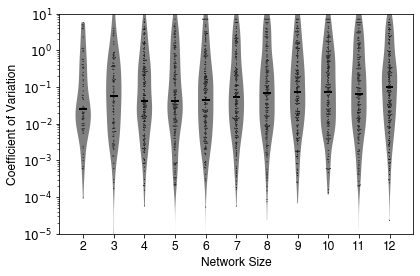

In [ ]:
fig, ax = plt.subplots()

coeff_noise_by_m = []
for m in m_list:
    m_i = m_list.index(m)
    coeff_noise = np.array(list(itertools.chain.from_iterable(coeff_noise_by_m_by_pset_by_species[m_i][param_set_i] for param_set_i in range(param_sets_per_m))))
    coeff_noise = coeff_noise[np.where(coeff_noise>0)]
    coeff_noise_by_m.append(np.log10(coeff_noise))
    

parts = ax.violinplot(positions = m_list,\
           dataset = coeff_noise_by_m,\
          #  labels = [str(m) for m in m_list],\
          showmedians=True,\
          showextrema=False,\
          showmeans=False,\
)
for face in parts['bodies']:
    face.set_facecolor('gray')
    face.set_alpha(1)
parts['cmedians'].set_color('k')
parts['cmedians'].set_linewidth(2)


subsample = 200
size = 1
for m,points in zip(m_list,coeff_noise_by_m):
    if len(points)>subsample:
        points = rng.choice(points,size=subsample,replace=False)
    subsample_df = pd.DataFrame({'m':np.full((len(points),),m),'y':points})
    sns.swarmplot(data=subsample_df,x='m',y='y',orient='v', native_scale=True,\
        color='k',size=size,alpha=1,edgecolor='none',ax=ax)

log_min_y = -5
log_max_y = 1
ax.set_ylim([log_min_y,log_max_y])
ax.set_yticks(range(log_min_y,log_max_y+1),labels=['$10^{{{}}}$'.format(x) for x in range(log_min_y,log_max_y+1)],minor=False)
ax.set_yticks(list(itertools.chain.from_iterable([[np.log10((10**x)*y) for y in np.arange(2,10)] \
            for x in range(log_min_y,log_max_y)])),minor=True)

ax.set_xticks(m_list)
_ = ax.set_ylabel('Coefficient of Variation')
_ = ax.set_xlabel('Network Size')

filename = f'coeff_var_by_network_size'
plt.tight_layout()
plt.savefig(str(pathlib.Path(out_dir,filename+'.pdf')),transparent=True,bbox_inches='tight')
fig.patch.set_facecolor('white')
plt.savefig(str(pathlib.Path(out_dir,filename+'.png')),dpi=900,bbox_inches='tight')

Coefficient of variation histogram by connectivity:

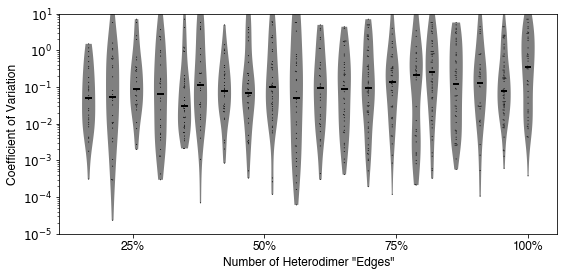

In [ ]:
m = 12
m_i = m_list.index(m)

fig, ax = plt.subplots(figsize=(8,4))

unique_num_edges = np.unique(num_edges_to_test_by_m[m_i])
connectivities = unique_num_edges/num_combos(m,2)
coeff_noise_by_num_edges = []
for num_edges_i,num_edges in enumerate(unique_num_edges):
    coeff_noise = []
    for param_set_i in np.where(num_edges_to_test_by_m[m_i]==num_edges)[0]:
        coeff_noise+= list(coeff_noise_by_m_by_pset_by_species[m_i][param_set_i])
    coeff_noise = np.array(coeff_noise)
    coeff_noise = coeff_noise[np.where(coeff_noise>0)]
    coeff_noise_by_num_edges.append(np.log10(coeff_noise))
    

parts = ax.violinplot(positions = connectivities,\
           dataset = coeff_noise_by_num_edges,\
          #  labels = [str(m) for m in m_list],\
          showmedians=True,\
          showextrema=False,\
          showmeans=False,\
            widths=0.025,
)
for face in parts['bodies']:
    face.set_facecolor('gray')
    face.set_alpha(1)

parts['cmedians'].set_color('k')
parts['cmedians'].set_linewidth(2)

subsample = 200
size = 1
for connectivity,points in zip(connectivities,coeff_noise_by_num_edges):
    if len(points)>subsample:
        points = rng.choice(points,size=subsample,replace=False)
    subsample_df = pd.DataFrame({'m':np.full((len(points),),connectivity),'y':points})
    sns.swarmplot(data=subsample_df,x='m',y='y',orient='v', native_scale=True,\
        color='k',size=size,alpha=1,edgecolor='none',ax=ax)

log_min_y = -5
log_max_y = 1
ax.set_ylim([log_min_y,log_max_y])
ax.set_yticks(range(log_min_y,log_max_y+1),labels=['$10^{{{}}}$'.format(x) for x in range(log_min_y,log_max_y+1)],minor=False)
ax.set_yticks(list(itertools.chain.from_iterable([[np.log10((10**x)*y) for y in np.arange(2,10)] \
            for x in range(log_min_y,log_max_y)])),minor=True)

_ = ax.set_xticks(np.linspace(0,1,5,endpoint=True))
_ = ax.set_xticklabels([f'{x:.0%}' for x in np.linspace(0,1,5,endpoint=True)])

_ = ax.set_ylabel('Coefficient of Variation')
_ = ax.set_xlabel('Number of Heterodimer "Edges"')

filename = f'{m}M_coeff_var_by_network_connectivity'
plt.tight_layout()
plt.savefig(str(pathlib.Path(out_dir,filename+'.pdf')),transparent=True,bbox_inches='tight')
fig.patch.set_facecolor('white')
plt.savefig(str(pathlib.Path(out_dir,filename+'.png')),dpi=900,bbox_inches='tight')

Coefficient of variation vs. abundance:

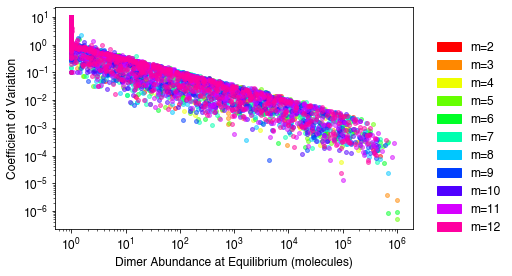

In [ ]:
fig, ax = plt.subplots()
cmap = plt.get_cmap('hsv')

for m in m_list:
    m_i = m_list.index(m)
    S_all = S_all_by_m[m_i]
    S_all[np.where(S_all<1e-3)] = 1e-3
    for param_set_i in range(param_sets_per_m):
        _ = ax.plot(S_all[input_i_by_m_by_pset[m_i][param_set_i],:,param_set_i]/unitless_conc_per_molecule,\
                    coeff_noise_by_m_by_pset_by_species[m_i][param_set_i],marker='.',\
                    markersize=8,linestyle='',color=cmap(m_i/len(m_list)),alpha=0.5)

_ = ax.set_ylabel('Coefficient of Variation')
_ = ax.set_xlabel('Dimer Abundance at Equilibrium (molecules)')

_ = ax.set_xscale('log')
_ = ax.set_yscale('log')

patches={}
for m_i,m in enumerate(m_list):
    patches[f'm={m}'] = mpatches.Patch(color=cmap(m_i/(len(m_list))),label=f'm={m}')

leg = fig.legend(bbox_to_anchor=(1, 0.5), loc='center left',facecolor='white',\
    handles=list(patches.values()),\
    edgecolor='white')

filename = f'coeff_var_vs_abundance_by_network_size'
plt.tight_layout()
plt.savefig(str(pathlib.Path(out_dir,filename+'.pdf')),transparent=True,bbox_inches='tight')
fig.patch.set_facecolor('white')
plt.savefig(str(pathlib.Path(out_dir,filename+'.png')),dpi=900,bbox_inches='tight')

Coefficient of variation vs. koff:

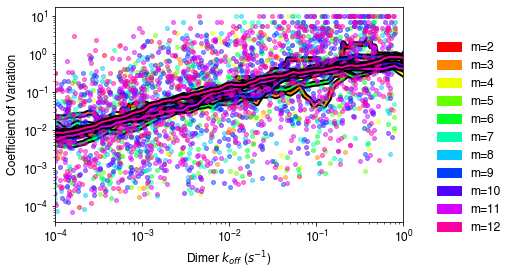

In [ ]:
fig, ax = plt.subplots()
cmap = plt.get_cmap('hsv')

for m in m_list:
    m_i = m_list.index(m)
    all_x_data = []
    all_y_data = []
    for param_set_i in range(param_sets_per_m):
        k_offs = k_offs_by_m_by_pset_by_species[m_i][param_set_i]
        coeff_noise = np.array(coeff_noise_by_m_by_pset_by_species[m_i][param_set_i][m:])
        all_x_data+=list(k_offs)
        all_y_data+=list(coeff_noise)
        _ = ax.plot(k_offs,coeff_noise,marker='.',\
                    markersize=8,linestyle='',color=cmap(m_i/len(m_list)),alpha=0.5)
    all_x_data = np.array(all_x_data)
    all_y_data = np.array(all_y_data)
    all_x_data,all_y_data=  all_x_data[np.where((all_x_data>0)&(all_y_data>0))],all_y_data[np.where((all_x_data>0)&(all_y_data>0))]
    x_window_means = moving_average(x_vals=np.log10(all_x_data), y_vals=np.log10(all_y_data), \
                                                      window_size=1, num_windows=200)
    _ = ax.plot(10**x_window_means[:,0],10**x_window_means[:,1],linestyle='-',marker='',color='k',alpha=1,lw=6)
    _ = ax.plot(10**x_window_means[:,0],10**x_window_means[:,1],linestyle='-',marker='',color=cmap(m_i/len(m_list)),alpha=1,lw=2)
    

_ = ax.set_ylabel('Coefficient of Variation')
_ = ax.set_xlabel(r'Dimer $k_{off}$ ($s^{-1}$)')

min_koff = 1e-12
max_koff = 1e2

_ = ax.set_xscale('log')
_ = ax.set_yscale('log')
_ = ax.set_xlim([10**min_log_koff,10**max_log_koff])

patches={}
for m_i,m in enumerate(m_list):
    patches[f'm={m}'] = mpatches.Patch(color=cmap(m_i/(len(m_list))),label=f'm={m}')

leg = fig.legend(bbox_to_anchor=(1, 0.5), loc='center left',facecolor='white',\
    handles=list(patches.values()),\
    edgecolor='white')

filename = f'coeff_var_vs_koff_by_network_size'
plt.tight_layout()
plt.savefig(str(pathlib.Path(out_dir,filename+'.pdf')),transparent=True,bbox_inches='tight')
fig.patch.set_facecolor('white')
plt.savefig(str(pathlib.Path(out_dir,filename+'.png')),dpi=900,bbox_inches='tight')

Dimer abundance at equilibrium vs. k_off 

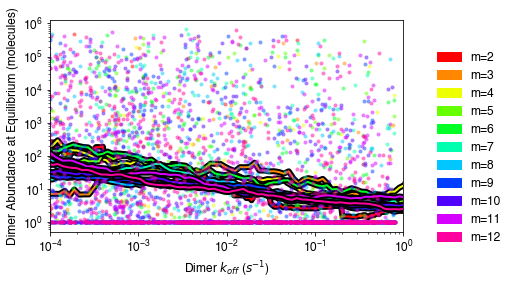

In [ ]:
fig, ax = plt.subplots()
cmap = plt.get_cmap('hsv')

for m in m_list:
    m_i = m_list.index(m)
    S_all = S_all_by_m[m_i]
    S_all[np.where(S_all<1e-3)] = 1e-3
    all_x_data = []
    all_y_data = []
    for param_set_i in range(param_sets_per_m):
        k_offs = k_offs_by_m_by_pset_by_species[m_i][param_set_i]
        abundances = S_all[input_i_by_m_by_pset[m_i][param_set_i],m:,param_set_i]/unitless_conc_per_molecule
        all_x_data+=list(k_offs)
        all_y_data+=list(abundances)
        _ = ax.plot(k_offs,abundances,marker='.',\
                    markersize=8,linestyle='',color=cmap(m_i/len(m_list)),alpha=0.5,markeredgewidth=0)
    all_x_data = np.array(all_x_data)
    all_y_data = np.array(all_y_data)
    all_x_data,all_y_data=  all_x_data[np.where((all_x_data>0)&(all_y_data>0))],all_y_data[np.where((all_x_data>0)&(all_y_data>0))]
    x_window_means = moving_average(x_vals=np.log10(all_x_data), y_vals=np.log10(all_y_data), \
                                                      window_size=1, num_windows=200)
    _ = ax.plot(10**x_window_means[:,0],10**x_window_means[:,1],linestyle='-',marker='',color='k',alpha=1,lw=6)
    _ = ax.plot(10**x_window_means[:,0],10**x_window_means[:,1],linestyle='-',marker='',color=cmap(m_i/len(m_list)),alpha=1,lw=2)

_ = ax.set_ylabel('Dimer Abundance at Equilibrium (molecules)')
_ = ax.set_xlabel(r'Dimer $k_{off}$ ($s^{-1}$)')

_ = ax.set_xscale('log')
_ = ax.set_yscale('log')
_ = ax.set_xlim([10**min_log_koff,10**max_log_koff])

patches={}
for m_i,m in enumerate(m_list):
    patches[f'm={m}'] = mpatches.Patch(color=cmap(m_i/(len(m_list))),label=f'm={m}')

leg = fig.legend(bbox_to_anchor=(1, 0.5), loc='center left',facecolor='white',\
    handles=list(patches.values()),\
    edgecolor='white')

filename = f'abundance_vs_koff_by_network_size'
plt.tight_layout()
plt.savefig(str(pathlib.Path(out_dir,filename+'.pdf')),transparent=True,bbox_inches='tight')
fig.patch.set_facecolor('white')
plt.savefig(str(pathlib.Path(out_dir,filename+'.png')),dpi=900,bbox_inches='tight')